In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from sklearn.decomposition import PCA

import os
import sys
sys.path.insert(0, '../src')

import utils.visualization as vis
import utils.preprocession as prep
import utils.metrics as met

from IPython.display import display

save_figures = []
save_figures.append('../figures')

In [2]:
results = prep.load_results(directory='../results/aqvaa')
results.tail()

,InitialData,Method,NumberQueries,Model,UpdateRate,NumberVoters,Seed,DataFrame
565,GPT-Replace-400-2,Uncertainty,30Q,XPLORE,5U,1200V,S97,User RMSE CRA ModelVersion ...
566,GPTmeans,Uncertainty,45Q,XPLORE,5U,1000V,S98,User RMSE CRA ModelVersion ...
567,GPTvoters,Uncertainty,25Q,XPLORE,5U,1000V,S91,User RMSE CRA ModelVersion ...
568,GPTvoters,Uncertainty,5Q,XPLORE,5U,1000V,S92,User RMSE CRA ModelVersion ...
569,GPT-Replace-400-40,Uncertainty,30Q,XPLORE,5U,1200V,S98,User RMSE CRA ModelVersion ...


### Outliers

In [37]:
df = results.loc[(results.NumberQueries=='10Q')
                & (results.Method=='Uncertainty')
                & (results.Seed=='S0')
                & (results.NumberVoters=='1200V')
                ]
df

,InitialData,Method,NumberQueries,Model,UpdateRate,NumberVoters,Seed,DataFrame
66,Coldstart,Uncertainty,10Q,XPLORE,5U,1200V,S0,User RMSE CRA ModelVersio...
132,GPT,Uncertainty,10Q,XPLORE,5U,1200V,S0,User RMSE CRA ModelVersio...
206,GPTmeans,Uncertainty,10Q,XPLORE,5U,1200V,S0,User RMSE CRA ModelVersio...
278,Candidates,Uncertainty,10Q,XPLORE,5U,1200V,S0,User RMSE CRA ModelVersio...
447,GPTvoters,Uncertainty,10Q,XPLORE,5U,1200V,S0,User RMSE CRA ModelVersio...
523,Voters,Uncertainty,10Q,XPLORE,5U,1200V,S0,User RMSE CRA ModelVersio...


In [38]:
datasets = ['GPT','GPTmeans', 'GPTvoters']
df_cst = df.loc[df.index[df.InitialData == 'Coldstart'][0], 'DataFrame']
df_gpt = {name: df.loc[df.index[df.InitialData == name][0], 'DataFrame'] for name in datasets}
df_cst

,User,RMSE,CRA,ModelVersion,TimeStamp,Queries
0,1160049,0.422596,0.166667,0,2024-09-25 10:07:16.372638,"['32221', '32231', '32234', '32235', '32242', ..."
1,717263,0.303637,0.583333,0,2024-09-25 10:07:16.468677,"['32229', '32231', '32234', '32240', '32242', ..."
2,231494,0.522664,0.000000,0,2024-09-25 10:07:16.564533,"['32215', '32221', '32245', '32246', '32249', ..."
3,1444728,0.382657,0.055556,0,2024-09-25 10:07:16.656930,"['32221', '32223', '32224', '32229', '32238', ..."
4,1208012,0.431519,0.000000,0,2024-09-25 10:07:16.752364,"['32215', '32221', '32223', '32246', '32249', ..."
...,...,...,...,...,...,...
1195,1095051,0.405491,0.166667,1195,2024-09-25 10:09:33.203448,"['32215', '32220', '32221', '32244', '32245', ..."
1196,407264,0.457860,0.000000,1195,2024-09-25 10:09:33.296304,"['32219', '32226', '32228', '32236', '32243', ..."
1197,1210442,0.367564,0.138889,1195,2024-09-25 10:09:33.389351,"['32228', '32234', '32243', '32244', '32245', ..."
1198,623830,0.433507,0.027778,1195,2024-09-25 10:09:33.482269,"['32220', '32221', '32231', '32244', '32245', ..."


<AxesSubplot:xlabel='ModelVersion'>

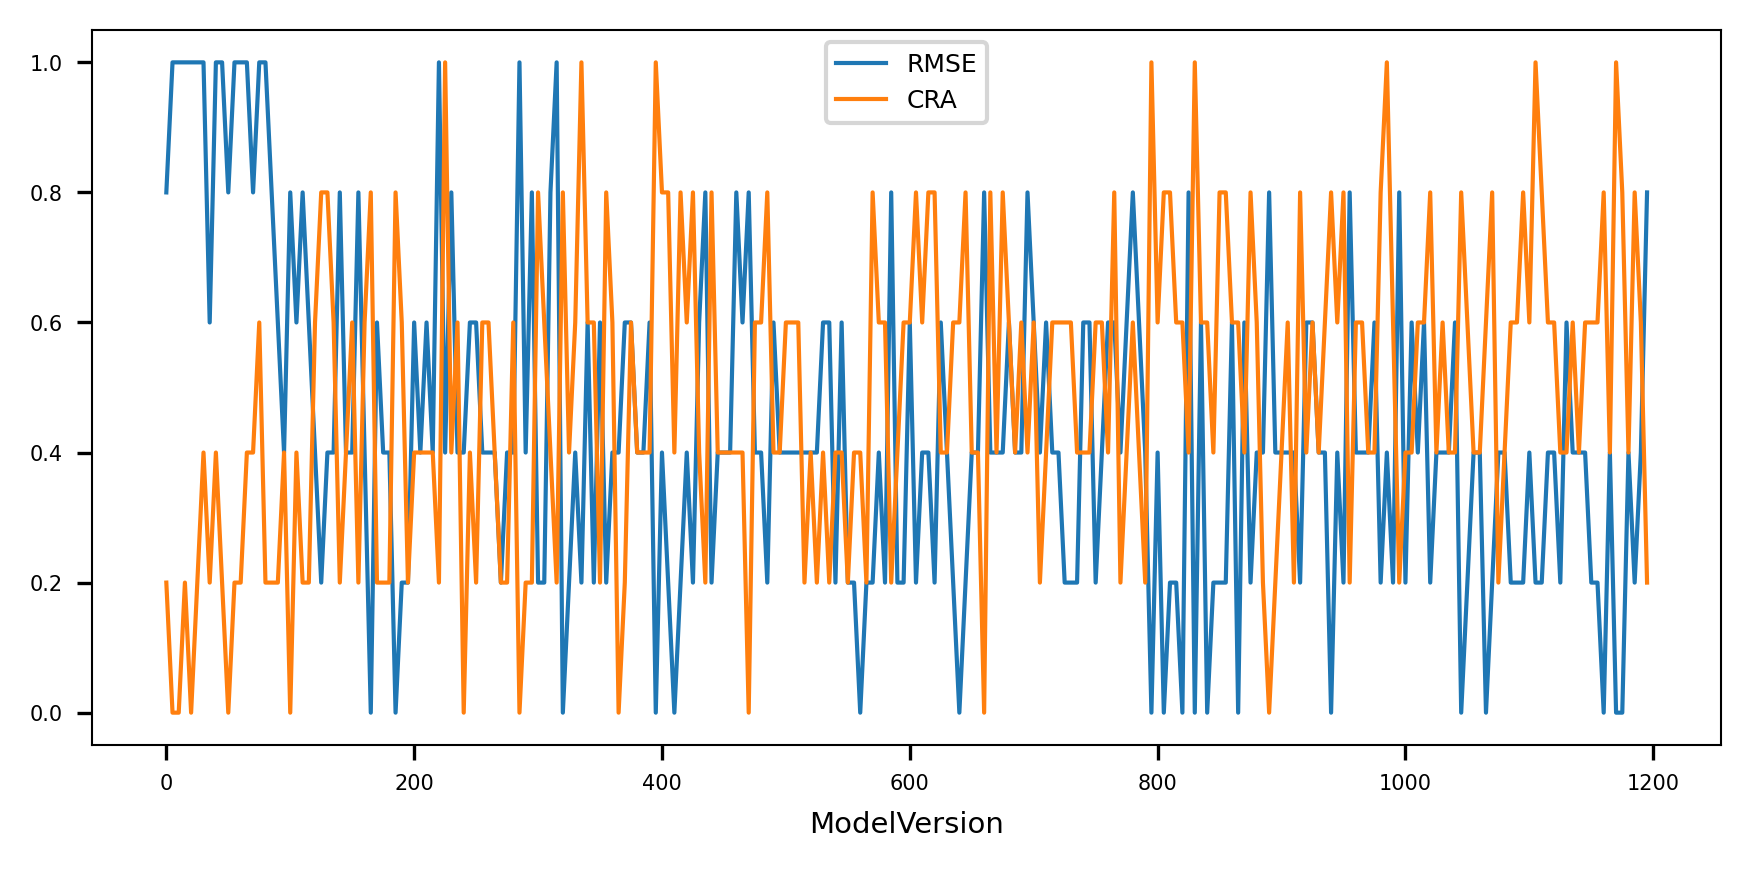

In [39]:
outliers = (df_gpt['GPTvoters'].loc[:,['RMSE', 'CRA']] < df_cst.loc[:,['RMSE', 'CRA']])
outliers['ModelVersion'] = df_cst.ModelVersion
outliers.groupby('ModelVersion').mean().plot()

[Text(0, 0.5, 'Fraction of users with better results in coldstart')]

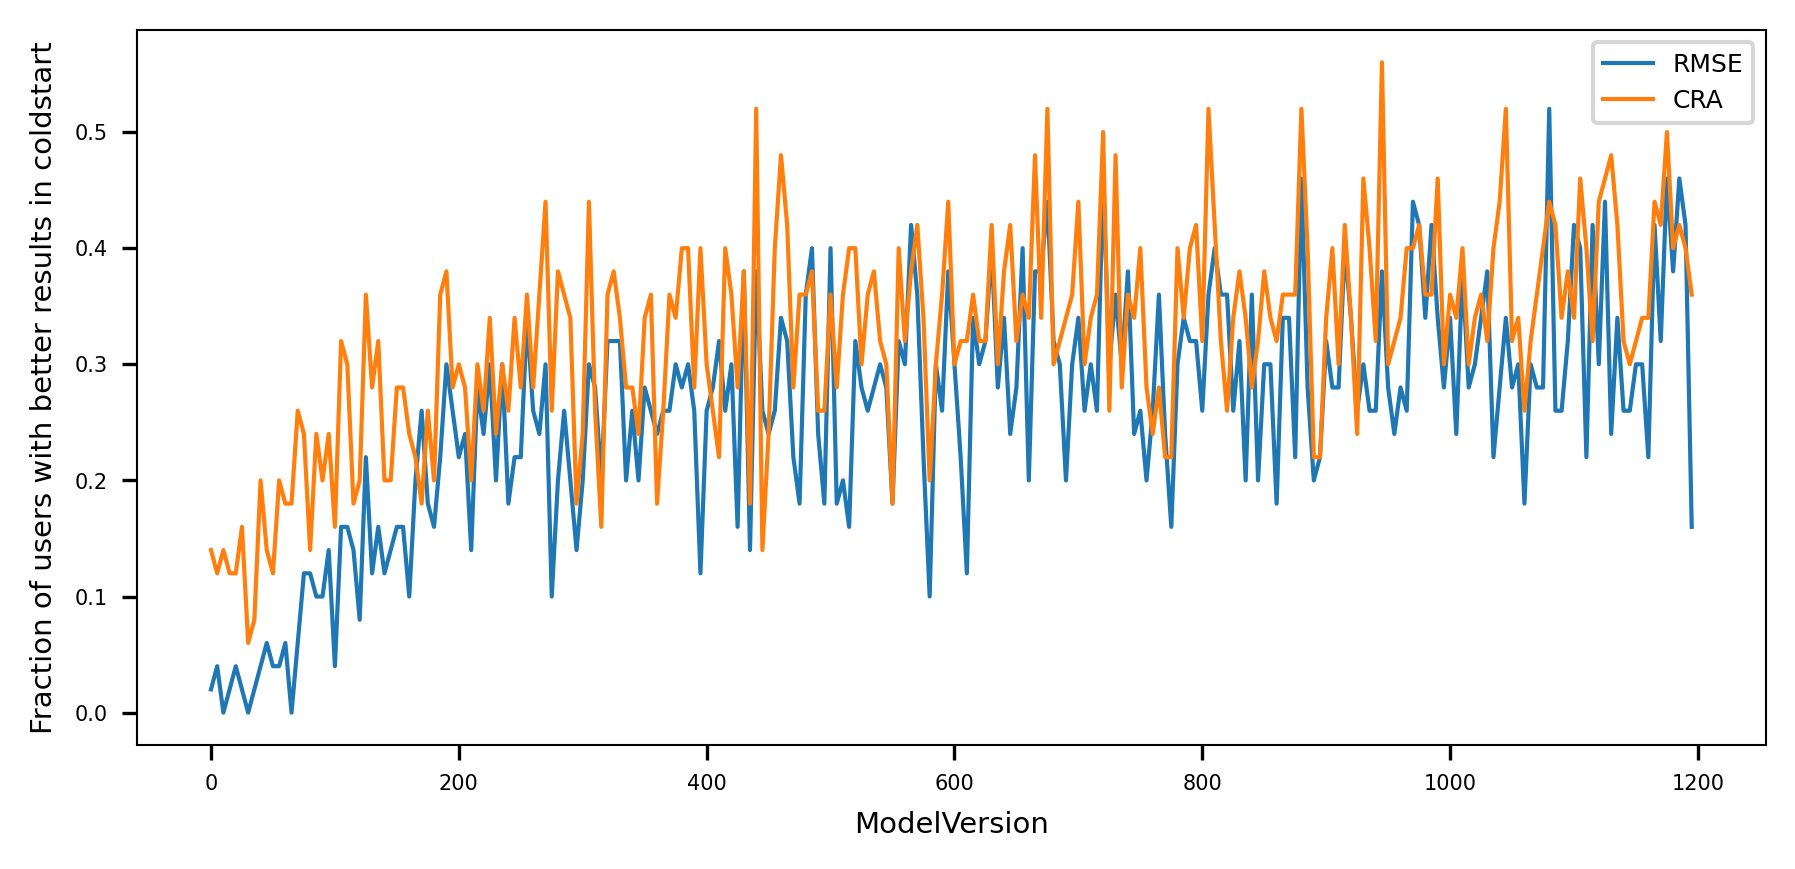

In [75]:
outliers = []
dataset = 'Candidates'

for s in range(0,10):
    df = results.loc[(results.NumberQueries=='10Q')
                    & (results.Method=='Uncertainty')
                    & (results.Seed==f'S{s}')
                    & (results.NumberVoters=='1200V')
                    ]

    df_cst = df.loc[df.index[df.InitialData == 'Coldstart'][0], 'DataFrame']
    df_gpt = df.loc[df.index[df.InitialData == dataset][0], 'DataFrame']
    outliers.append((df_gpt.loc[:,['RMSE', 'CRA']] < df_cst.loc[:,['RMSE', 'CRA']]))

outliers = pd.DataFrame(np.concatenate([np.array(outliers).mean(axis=0),df_cst.ModelVersion.values.reshape(-1,1)], axis=1),
             columns=['RMSE', 'CRA', 'ModelVersion'])
outliers['RMSE'] = 1- outliers['RMSE']
ax = outliers.groupby('ModelVersion').mean().plot()
ax.set(ylabel='Fraction of users with better results in coldstart')

### Extremity

In [3]:
import pickle 
with open('../results/xplore/xplore.pickle', 'rb') as file:
    xplore = pickle.load(file)

candidates = pd.read_csv('../data/candidates.csv', index_col=0)
candidate_reactions = pd.read_csv('../data/candidates_reactions.csv', index_col=0)

candidates['extremity'] = 100*np.linalg.norm(xplore.embedding, axis=1)**2
candidates.groupby('list').extremity.mean()

list
EDU       28.077069
EVP       13.041541
FDP       34.705706
GLP       33.604387
Grüne     51.109820
Mitte     10.503514
SP        55.302868
SVP       43.831464
Übrige    34.229048
Name: extremity, dtype: float64

In [4]:
voter_reactions = pd.read_csv('../data/voters_reactions.csv', index_col=0)
neighbors = met.NearestCandidates(candidate_reactions, k=36)
recommendations = voter_reactions.apply(neighbors.recommend, axis=1)
recommendations

voter
111        [2072, 5157, 4725, 295, 182, 4459, 5801, 5742,...
189        [5216, 2761, 539, 4814, 2753, 5195, 712, 2840,...
240        [5121, 5594, 1919, 5065, 981, 2494, 4617, 875,...
344        [4846, 4226, 3326, 3052, 1769, 1955, 340, 5655...
458        [2609, 3373, 5560, 2867, 1868, 2910, 4319, 575...
                                 ...                        
1661805    [2839, 4643, 4554, 5385, 5326, 4012, 2011, 338...
1661969    [4417, 5862, 2355, 5301, 1750, 5687, 535, 5134...
1661970    [5486, 5402, 5484, 5459, 3255, 3161, 841, 1117...
1662350    [340, 1391, 3639, 2755, 124, 2421, 1231, 847, ...
1662477    [2044, 536, 3572, 5609, 5657, 1456, 2010, 5526...
Length: 12315, dtype: object

In [5]:
def mean_extremity(recommendations: str):
    return candidates.loc[pd.eval(recommendations)].extremity.mean()

voter_extremity = recommendations.apply(mean_extremity)
voter_extremity

voter
111        49.677197
189        10.301087
240        43.035950
344        14.354295
458        34.400927
             ...    
1661805    38.064695
1661969    67.765966
1661970    43.630773
1662350    21.510119
1662477    64.326658
Length: 12315, dtype: float64

In [ ]:
voter_extremity.to_csv('../results/analysis/voter_extremity.csv')
voter_extremity = pd.read_csv('../results/analysis/voter_extremity.csv', index_col=0)

In [8]:
df = results.loc[(results.NumberQueries=='30Q')
                & (results.Method=='Uncertainty')
                & (results.NumberVoters=='1000V')
                & (results.InitialData=='Coldstart')
                ]
df

,InitialData,Method,NumberQueries,Model,UpdateRate,NumberVoters,Seed,DataFrame
7,Coldstart,Uncertainty,30Q,XPLORE,5U,1000V,S93,User RMSE CRA ModelVersion ...
26,Coldstart,Uncertainty,30Q,XPLORE,5U,1000V,S92,User RMSE CRA ModelVersion ...
42,Coldstart,Uncertainty,30Q,XPLORE,5U,1000V,S90,User RMSE CRA ModelVersion ...
63,Coldstart,Uncertainty,30Q,XPLORE,5U,1000V,S91,User RMSE CRA ModelVersion ...
81,Coldstart,Uncertainty,30Q,XPLORE,5U,1000V,S95,User RMSE CRA ModelVersion ...
100,Coldstart,Uncertainty,30Q,XPLORE,5U,1000V,S94,User RMSE CRA ModelVersion ...
119,Coldstart,Uncertainty,30Q,XPLORE,5U,1000V,S96,User RMSE CRA ModelVersion ...
140,Coldstart,Uncertainty,30Q,XPLORE,5U,1000V,S97,User RMSE CRA ModelVersion ...
487,Coldstart,Uncertainty,30Q,XPLORE,5U,1000V,S99,User RMSE CRA ModelVersion ...
502,Coldstart,Uncertainty,30Q,XPLORE,5U,1000V,S98,User RMSE CRA ModelVersion ...


In [9]:
run_extremity = []
for run in df.index.values:
    A = df.loc[run].DataFrame
    extremity = A['Neighbors'].apply(mean_extremity)
    run_extremity.append(pd.DataFrame({'Seed': df.loc[run,'Seed'], 
                                       'User': A.User.values, 
                                       'ModelVersion': A.ModelVersion.values, 
                                       'ExtremityEstimate': extremity.values, 
                                       'ExtremityTrue': voter_extremity.loc[A.User].values}))
run_extremity = pd.concat(run_extremity)
run_extremity['ExtremityDiff'] = run_extremity['ExtremityEstimate'] - run_extremity['ExtremityTrue']
run_extremity

,Seed,User,ModelVersion,ExtremityEstimate,ExtremityTrue,ExtremityDiff
0,S93,499722,0,8.582275,28.038574,-19.456299
1,S93,346130,0,13.428954,36.543409,-23.114456
2,S93,297605,0,19.089866,72.738904,-53.649038
3,S93,1114893,0,24.791181,36.349812,-11.558631
4,S93,1242166,0,8.681599,14.905348,-6.223749
...,...,...,...,...,...,...
995,S98,1376730,995,48.474085,53.911097,-5.437012
996,S98,1006348,995,39.714485,50.541372,-10.826887
997,S98,724814,995,30.557029,48.342775,-17.785746
998,S98,472395,995,48.556574,57.312806,-8.756232


<Axes: xlabel='ModelVersion'>

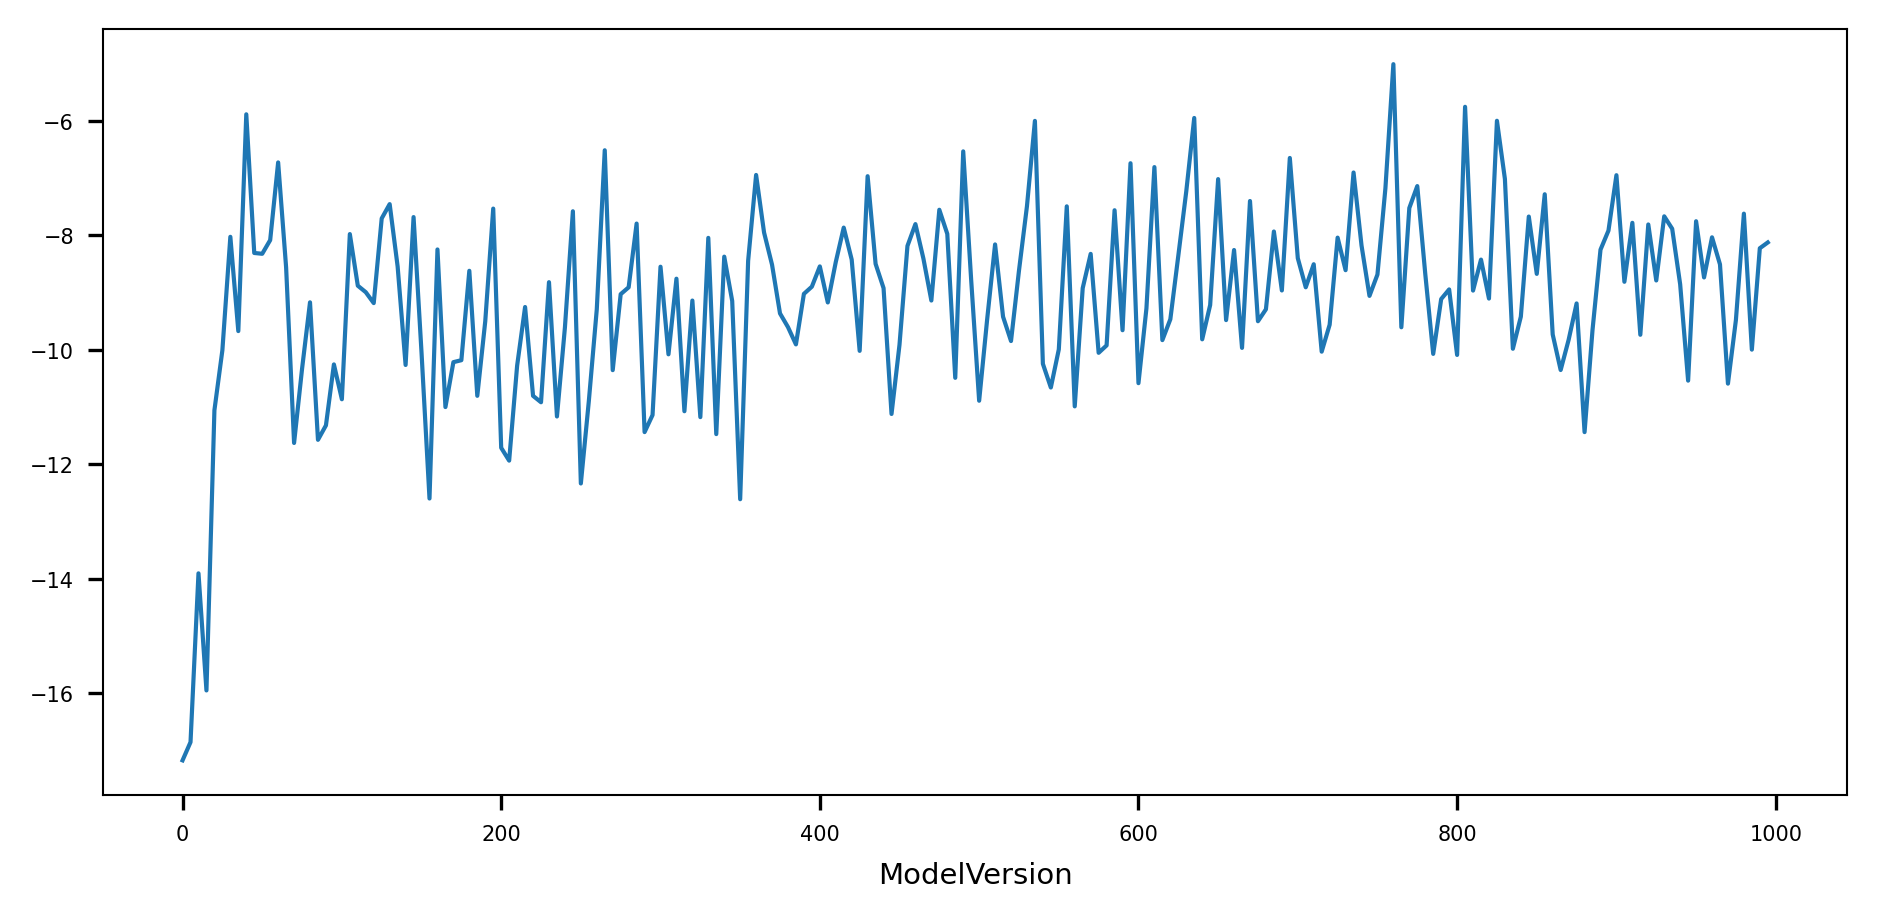

In [10]:
run_extremity.groupby('ModelVersion').ExtremityDiff.mean().plot()

In [11]:
mean = run_extremity.groupby('Seed').ExtremityDiff.mean()
std = run_extremity.groupby('Seed').ExtremityDiff.std()
pd.DataFrame([mean, std], index=['mean', 'std'])

Seed,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
mean,-10.856313,-8.652449,-10.352388,-8.788322,-8.759968,-8.979456,-8.362345,-8.745882,-8.509653,-9.226917
std,8.940980,9.814094,9.465967,9.328372,9.462429,8.773423,8.646713,9.406881,9.143644,9.442051


In [12]:
mean = run_extremity.ExtremityDiff.mean()
std = run_extremity.ExtremityDiff.std()#/np.sqrt(len(run_extremity.index))
pd.DataFrame([mean, std], index=['mean', 'std'])

,0
mean,-9.123369
std,9.277633


In [13]:
run_extremity[['ExtremityTrue', 'ExtremityDiff']].corr()

,ExtremityTrue,ExtremityDiff
ExtremityTrue,1.000000,-0.564284
ExtremityDiff,-0.564284,1.000000


In [ ]:
run_extremity.to_csv('../results/analysis/Extremity_Coldstart_K30.csv')

#### Visualize

In [19]:
run_extremity = pd.read_csv('../results/analysis/Extremity_Coldstart_K30.csv', index_col=0)

In [20]:
def compute_run_extremity(dataset, K):
    df = results.loc[(results.NumberQueries==f'{K}Q')
                        & (results.Method=='Uncertainty')
                        & (results.NumberVoters=='1000V')
                        & (results.InitialData==dataset)
                        ]

    run_extremity = []
    for run in df.index.values:
        A = df.loc[run].DataFrame
        extremity = A['Neighbors'].apply(mean_extremity)
        run_extremity.append(pd.DataFrame({'Seed': df.loc[run,'Seed'], 
                                        'User': A.User.values, 
                                        'ModelVersion': A.ModelVersion.values, 
                                        'ExtremityEstimate': extremity.values, 
                                        'ExtremityTrue': voter_extremity.loc[A.User].values}))
    return pd.concat(run_extremity)

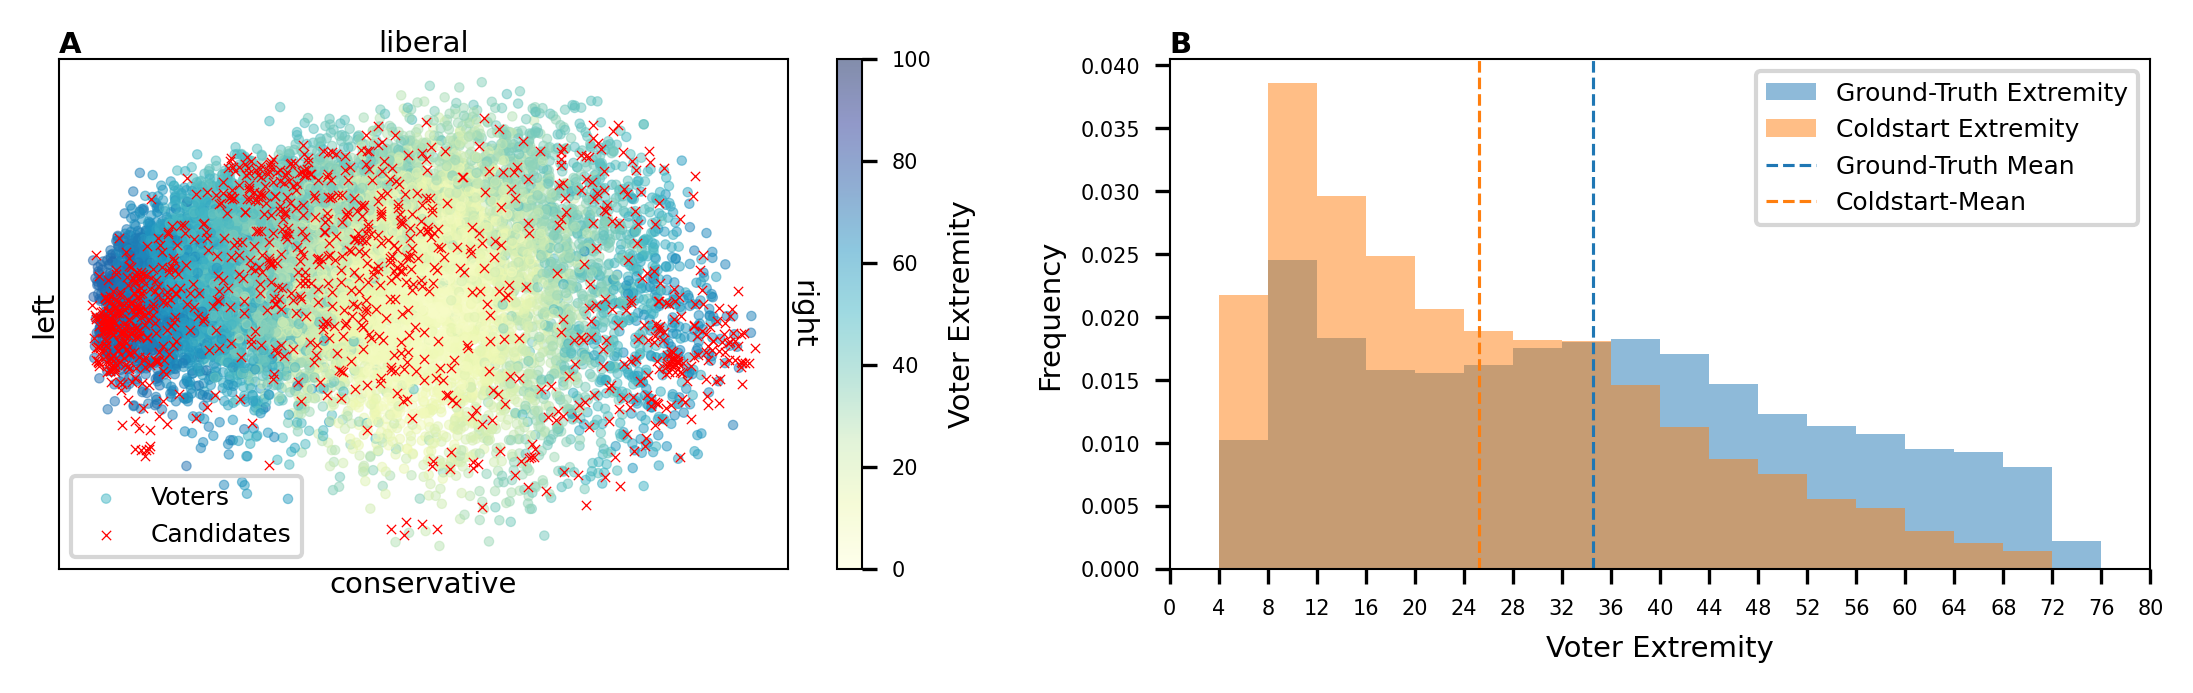

In [24]:
# Perform PCA on voter reactions
pca = PCA(n_components=2)
X_voters = pca.fit_transform(voter_reactions)
X_candidates = pca.transform(candidate_reactions)

# Create a scatter plot
fig, (ax, bx) = plt.subplots(1, 2, figsize=(vis.textwidth, 0.3*vis.textwidth))
scatter = ax.scatter(X_voters[:, 0], -X_voters[:, 1], c=voter_extremity, label='Voters', lw=0.3, s=5, cmap='YlGnBu', vmin=0, vmax=100, alpha=0.5)
fig.colorbar(scatter, ax=ax, label='Voter Extremity')
ax.scatter(X_candidates[:, 0], -X_candidates[:, 1], color='red', marker='x',lw=0.3, s=5, label='Candidates')
ax.set(aspect='equal',xticks=[], yticks=[])
ax.legend()
# Add text annotations
ax.text(-0.02, 0.5, 'left', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(1.02, 0.5, 'right', va='center', ha='center', rotation=270, transform=ax.transAxes)
ax.text(0.5, 1.03, 'liberal', va='center', ha='center', transform=ax.transAxes)
ax.text(0.5, -0.03, 'conservative', va='center', ha='center', transform=ax.transAxes)

xmax = 80#1.05*max(voter_extremity.max(), run_extremity['ExtremityEstimate'].max())
bins = np.linspace(0,xmax,21)

# Calculate histogram for the voter extremity
hist_voter, bin_edges = np.histogram(voter_extremity, bins=bins, density=True)
hist_run, bin_edges = np.histogram(run_extremity['ExtremityEstimate'], bins=bins, density=True)
# hist_gpt, bin_edges = np.histogram(run_extremity_GPTvoters['ExtremityEstimate'], bins=bins, density=True)
ymax = 1.05 * max(hist_voter.max(), hist_run.max())

# bx.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))  # For one decimal place

a = voter_extremity.plot.hist(bins=bins, density=True, alpha=0.5, ax=bx, label='Ground-Truth Extremity')
run_extremity['ExtremityEstimate'].plot.hist(bins=bins, density=True, alpha=0.5, ax=bx, label='Coldstart Extremity')
# run_extremity_GPTvoters['ExtremityEstimate'].plot.hist(bins=bins, density=True, alpha=0.5, ax=bx, label='GPTvoters Extremity')

bx.set(xlabel='Voter Extremity', ylabel='Frequency',
       xlim=(0,xmax), ylim=(0,ymax), xticks=bins)
bx.axvline(voter_extremity.mean(), color='C0', linestyle='--', lw=0.75, label='Ground-Truth Mean')
bx.axvline(run_extremity['ExtremityEstimate'].mean(), color='C1', linestyle='--', lw=0.75,  label='Coldstart-Mean')
# bx.axvline(run_extremity_GPTvoters['ExtremityEstimate'].mean(), color='C2', linestyle='--', lw=0.5,  label='GPTvoters-Mean')
bx.legend()

fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=ax.transAxes)
fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=bx.transAxes)

fig.tight_layout()
vis.savefig(fig, title='XPLORE_Voter_Extremity', destinations=save_figures)


##### Run All

In [ ]:
number_queries_list = list(range(5,46,5))
datasets = ['Coldstart', 'GPT' , 'GPTmeans', 'GPTvoters', 'Candidates']

means = []
stds = []
for K in number_queries_list:
    print(f'Number of queries: {K}')
    tmp_means = []
    tmp_stds = []
    for data in datasets:
        run_extremity = compute_run_extremity(data, K)
        run_extremity['ExtremityDiff'] = run_extremity['ExtremityEstimate'] - run_extremity['ExtremityTrue']
        tmp_means.append(run_extremity.ExtremityDiff.mean())
        tmp_stds.append(run_extremity.ExtremityDiff.std())
    means.append(tmp_means)
    stds.append(tmp_stds)


Number of queries: 5
Number of queries: 10
Number of queries: 15
Number of queries: 20
Number of queries: 25
Number of queries: 30
Number of queries: 35
Number of queries: 40
Number of queries: 45


In [ ]:
m = pd.DataFrame(means, index=number_queries_list, columns=datasets)
s = pd.DataFrame(stds, index=number_queries_list, columns=datasets)/np.sqrt(10000)*1.96

# Create a new DataFrame with the formatted strings
formatted_df = m.round(1).astype(str) + " ± " + s.round(1).astype(str)

formatted_df

,Coldstart,GPT,GPTmeans,GPTvoters,Candidates
5,-20.7 ± 0.3,-24.9 ± 0.3,-24.5 ± 0.3,-22.7 ± 0.3,-22.7 ± 0.3
10,-17.9 ± 0.3,-19.6 ± 0.3,-21.6 ± 0.3,-18.7 ± 0.3,-16.4 ± 0.3
15,-15.9 ± 0.3,-15.5 ± 0.2,-18.7 ± 0.3,-14.4 ± 0.3,-12.6 ± 0.2
20,-13.4 ± 0.2,-12.1 ± 0.2,-15.8 ± 0.2,-10.9 ± 0.2,-10.0 ± 0.2
25,-10.6 ± 0.2,-9.4 ± 0.2,-13.1 ± 0.2,-8.4 ± 0.2,-8.1 ± 0.2
30,-9.1 ± 0.2,-7.4 ± 0.2,-10.9 ± 0.2,-6.6 ± 0.2,-6.8 ± 0.2
35,-7.5 ± 0.2,-5.8 ± 0.1,-8.7 ± 0.2,-5.3 ± 0.2,-5.2 ± 0.1
40,-5.9 ± 0.1,-4.3 ± 0.1,-7.0 ± 0.1,-4.3 ± 0.1,-4.0 ± 0.1
45,-4.6 ± 0.1,-2.9 ± 0.1,-5.2 ± 0.1,-3.3 ± 0.1,-2.9 ± 0.1


In [21]:
# Define the file path
file_path = '../reports/PLOS Paper/tables/Extremity.tex'
caption = 'Extremity estimation error in percentage points for different datasets and number of queries.'

table = formatted_df.copy()
table.index.name = 'K'
table = table.reset_index()

table_str = table.to_latex(index=False ,caption=caption, label='tab:extremity', escape=False)
## Convert DataFrame to LaTeX table and save it to a file
with open(file_path, 'w') as f:
    f.write(table_str)